# Traffic Prediction Example
### _Uncertainty Quantification_ Workshop for ODSC West Conference 
#### (scheduled for November 2nd, 2022 2:00 PM PST)
### by Serg Masís ([LinkedIn](https://www.linkedin.com/in/smasis/), [Twitter](https://twitter.com/smasis), [Serg.ai](https://www.serg.ai/), [Amazon](https://www.amazon.com/kindle-dbs/entity/author/B08PQ8P9BS?_encoding=UTF8&node=283155&offset=0&pageSize=12&searchAlias=stripbooks&sort=author-sidecar-rank&page=1&langFilter=default#formatSelectorHeader), [Github](https://github.com/smasis001))

**The Mission**

Vehicle traffic volumes are a rising problem worldwide. Gridlock impacts most cities whenever traffic exceeds highway capacity, and that's bound to happen at least most weekdays during rush hours.

Imagine you've been asked to create a model that predicts traffic volume for a Minneapolis highway. Construction needs it so that they can anticipate which hours during each day they can work on a highway expansion project. However, they need to factor uncertainty because they are not allowed to work when traffic volume exceeds a quarter capacity. 

**The Solution**

This notebook will walk through:



- Preparing the weather features with rolling aggregations
- Understanding how much uncertainty is carried in the data. In particular the variability present in traffic volumes.
- Hyperparameter tuning with cross-validation
- Inspecting the predictive performance
- Introducing uncertainty quantification
- Computing extrinsic UQ with conformal prediction
- Calculating intrinsic UQ with quantile regression

## 1) The Preparations

### 1.1) Installing the Libraries

In [ ]:
!pip install numpy pandas scikit-learn matplotlib seaborn tqdm torch

In [ ]:
!pip install lightgbm uq360 mapie

### 1.2) Loading the Libraries

In [1]:
import math
import os
import numpy as np
import pandas as pd

import copy
from tqdm.notebook import tqdm
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import torch

from mapie.regression import MapieRegressor
from mapie.metrics import regression_coverage_score
from uq360.algorithms.quantile_regression import QuantileRegression
from uq360.metrics import picp, mpiw

import matplotlib.pyplot as plt
import seaborn as sns

### 1.3) Understanding the Data

#### 1.3.1) Loading the Data

In [3]:
url = "https://github.com/smasis001/odsc-west-2022/blob/main/data/traffic-volume-3e.csv?raw=true"
traffic_df = pd.read_csv(url)

traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52536 entries, 0 to 52535
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date_time          52536 non-null  object 
 1   dow                52536 non-null  int64  
 2   hr                 52536 non-null  int64  
 3   temp_1h            52536 non-null  float64
 4   rain_1h            52536 non-null  float64
 5   snow_1h            52536 non-null  float64
 6   cloud_coverage_1h  52536 non-null  float64
 7   weather_1h         52536 non-null  object 
 8   is_holiday         52536 non-null  int64  
 9   traffic_volume     52536 non-null  int64  
dtypes: float64(4), int64(4), object(2)
memory usage: 4.0+ MB


In [122]:
traffic_df.sample(n=15)

,date_time,dow,hr,temp_1h,rain_1h,snow_1h,cloud_coverage_1h,weather_1h,is_holiday,traffic_volume
32235,2016-06-07 03:00:00,1,3,13.359998,0.0,0.00,0.000000,Clear,0,337
15952,2014-07-29 16:00:00,1,16,25.869999,0.0,0.00,45.000000,Unknown,0,6756
29409,2016-02-10 09:00:00,2,9,-16.180002,0.0,0.00,100.000000,Unknown,0,5287
43425,2017-09-16 09:00:00,5,9,20.309998,0.2,0.00,61.000000,Rain,0,3853
30082,2016-03-09 10:00:00,2,10,2.619998,0.0,0.00,100.000000,Unknown,0,4598
25633,2015-09-06 01:00:00,6,1,26.529999,0.0,0.00,28.500002,Clear,0,869
6881,2013-07-16 17:00:00,1,17,32.900000,0.0,0.00,46.000000,Clear,0,6100
42108,2017-07-23 12:00:00,6,12,22.249998,0.0,0.00,70.000000,Clouds,0,4257
3350,2013-02-19 14:00:00,1,14,-15.250002,0.0,0.00,100.000000,Clouds,0,5120
8653,2013-09-28 13:00:00,5,13,16.619999,1.4,0.00,100.000000,Unknown,0,5084


#### 1.3.2) Data Dictionary

- **date_time**: date time for `traffic_volume`
- **dow**: day of week of `date_time` (0: Monday, 6: Sunday)
- **hr**: hour of `date_time` (0-23)
- **temp_1h**: average temperature the preceeding hour before `date_time` (celsius)
- **rain_1h**: total rain fall the preceeding hour before `date_time` (mm)
- **snow_1h**: total snow fall the preceeding hour before `date_time` (mm)
- **cloud_coverage_1h**: percentage of cloud coverage the preceeding hour before `date_time` (%)
- **weather_1h**: a text description of the weather the preceeding hour before `date_time`
- **is_holiday**: if the day for `date_time` is a holiday
- **traffic_volume**: total number of vehicles in the hour of `date_time` 

`weather_1h` has the following values:

In [4]:
traffic_df.weather_1h.value_counts()

Clouds          15114
Clear           13360
Unknown         11976
Rain             4769
Mist             3069
Snow             2297
Haze              766
Drizzle           515
Thunderstorm      453
Fog               201
Other              16
Name: weather_1h, dtype: int64

### 1.4) Preparing the Data

#### 1.4.1) Categoricaly Encoding

In [5]:
traffic_mod_df = traffic_df.copy()
traffic_mod_df = pd.get_dummies(traffic_mod_df, columns=['weather_1h'])

#### 1.4.2) Set `date_time` as the index

In [6]:
traffic_mod_df['date_time'] = pd.to_datetime(traffic_mod_df.date_time)
traffic_mod_df.set_index('date_time', inplace=True)

#### 1.4.3) Drop unnecessary columns

In [8]:
drop_cols_l = ['weather_1h_Clouds', 'weather_1h_Drizzle', 'weather_1h_Fog', 'weather_1h_Other',\
               'weather_1h_Snow', 'weather_1h_Thunderstorm']
traffic_mod_df = traffic_mod_df.drop(drop_cols_l, axis=1)

traffic_mod_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52536 entries, 2012-10-03 00:00:00 to 2018-09-30 23:00:00
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   dow                 52536 non-null  int64  
 1   hr                  52536 non-null  int64  
 2   temp_1h             52536 non-null  float64
 3   rain_1h             52536 non-null  float64
 4   snow_1h             52536 non-null  float64
 5   cloud_coverage_1h   52536 non-null  float64
 6   is_holiday          52536 non-null  int64  
 7   traffic_volume      52536 non-null  int64  
 8   weather_1h_Clear    52536 non-null  uint8  
 9   weather_1h_Haze     52536 non-null  uint8  
 10  weather_1h_Mist     52536 non-null  uint8  
 11  weather_1h_Rain     52536 non-null  uint8  
 12  weather_1h_Unknown  52536 non-null  uint8  
dtypes: float64(4), int64(4), uint8(5)
memory usage: 3.9 MB


#### 1.4.4) Rolling aggregations

In [9]:
raggs_l = [('temp_1h', 6, 'min', False),
           ('rain_1h', 9, 'sum', True),
           ('snow_1h', 18, 'sum', True),
           ('cloud_coverage_1h', 4, 'min', False),
           ('cloud_coverage_1h', 4, 'max', False),
           ('cloud_coverage_1h', 4, 'sum', False),
           ('weather_1h_Haze', 13, 'sum', True),
           ('weather_1h_Mist', 14, 'sum', True),
           ('weather_1h_Rain', 6, 'sum', True),
           ('weather_1h_Unknown', 2, 'sum', True)]

for col, lags, agg, drop_col in tqdm(raggs_l):
    traffic_mod_df = traffic_mod_df.join(traffic_mod_df[col].rolling(lags).\
                                   agg({f"{col.replace('_1h','')}_{lags}h_{agg}":agg}))
    if drop_col:
        traffic_mod_df = traffic_mod_df.drop(col, axis=1)

traffic_mod_df.dropna(inplace=True)

In [10]:
traffic_mod_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52519 entries, 2012-10-03 17:00:00 to 2018-09-30 23:00:00
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   dow                     52519 non-null  int64  
 1   hr                      52519 non-null  int64  
 2   temp_1h                 52519 non-null  float64
 3   cloud_coverage_1h       52519 non-null  float64
 4   is_holiday              52519 non-null  int64  
 5   traffic_volume          52519 non-null  int64  
 6   weather_1h_Clear        52519 non-null  uint8  
 7   temp_6h_min             52519 non-null  float64
 8   rain_9h_sum             52519 non-null  float64
 9   snow_18h_sum            52519 non-null  float64
 10  cloud_coverage_4h_min   52519 non-null  float64
 11  cloud_coverage_4h_max   52519 non-null  float64
 12  cloud_coverage_4h_sum   52519 non-null  float64
 13  weather_Haze_13h_sum    52519 non-null  float64
 14  wea

### 1.5) Understanding the target variable `traffic_volume`

#### 1.5.1) By Week

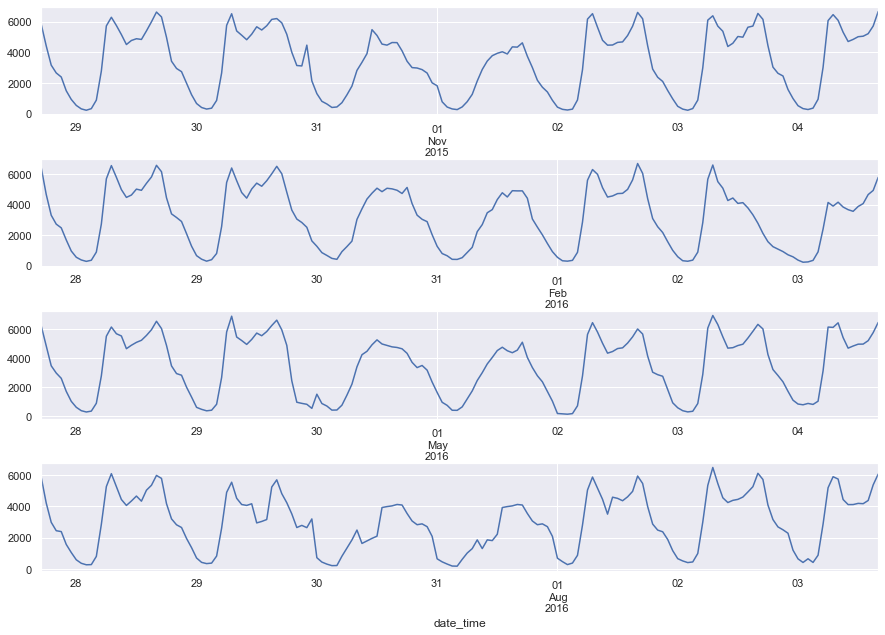

In [11]:
lb = 168

sns.set()
fig, (ax0,ax1,ax2,ax3) = plt.subplots(4,1, figsize=(15,8))
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.4)
traffic_mod_df[(lb*160):(lb*161)].traffic_volume.plot(ax=ax0)
traffic_mod_df[(lb*173):(lb*174)].traffic_volume.plot(ax=ax1)
traffic_mod_df[(lb*186):(lb*187)].traffic_volume.plot(ax=ax2)
traffic_mod_df[(lb*199):(lb*200)].traffic_volume.plot(ax=ax3)
plt.show()

#### 1.5.2) Aggregated by type of day (holiday, weekend, weekday)

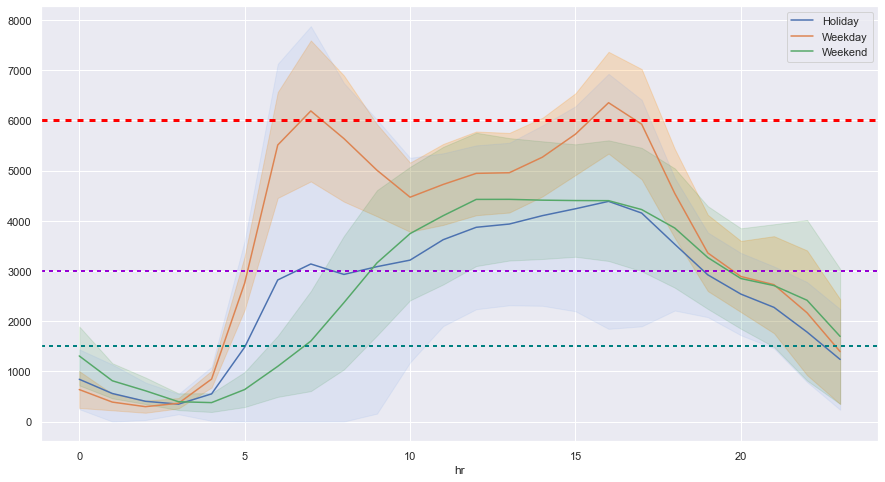

In [12]:
weekend_df = traffic_mod_df[['hr', 'dow', 'is_holiday', 'traffic_volume']].copy()
weekend_df['type_of_day'] = np.where(weekend_df.is_holiday == 1, 'Holiday',
                                   np.where(weekend_df.dow >= 5, 'Weekend', 'Weekday'))
weekend_df = weekend_df.groupby(['type_of_day','hr'])['traffic_volume'].agg(['mean','std']).\
                reset_index().pivot(index='hr', columns='type_of_day', values=['mean', 'std'])
weekend_df.columns = ['_'.join(col).strip().replace('mean_','')\
                      for col in weekend_df.columns.values]
fig, ax = plt.subplots(figsize=(15,8))
weekend_df[['Holiday','Weekday','Weekend']].plot(ax=ax)
plt.fill_between(weekend_df.index,\
                 np.maximum(weekend_df.Weekday - 2 * weekend_df.std_Weekday, 0),\
                 weekend_df.Weekday + 2 * weekend_df.std_Weekday,
                 color='darkorange', alpha=0.2)
plt.fill_between(weekend_df.index,\
                 np.maximum(weekend_df.Weekend - 2 * weekend_df.std_Weekend, 0),\
                 weekend_df.Weekend + 2 * weekend_df.std_Weekend,
                 color='green', alpha=0.1)
plt.fill_between(weekend_df.index,\
                 np.maximum(weekend_df.Holiday - 2 * weekend_df.std_Holiday, 0),\
                 weekend_df.Holiday + 2 * weekend_df.std_Holiday,
                 color='cornflowerblue', alpha=0.1)
ax.axhline(y=6000, linewidth=3, color='red', dashes=(2,2))
ax.axhline(y=3000, linewidth=2, color='darkviolet', dashes=(2,2))
ax.axhline(y=1500, linewidth=2, color='teal', dashes=(2,2))
plt.show()

### 1.6) Split Dataset

**Train/test Split**

In [13]:
train_df = traffic_mod_df[:-52*lb]
test_df = traffic_mod_df[-52*lb:]

We are reserving the last 52 weeks as the test dataset. You can visualize it like this.

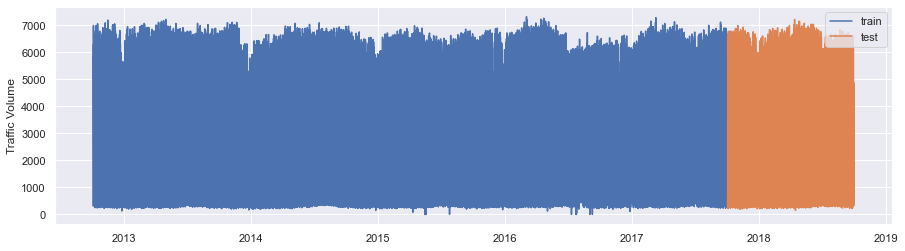

In [15]:
plt.figure(figsize=(15,4))
plt.plot(train_df.index.values, train_df.traffic_volume.values,\
         label='train')
plt.plot(test_df.index.values, test_df.traffic_volume.values,\
         label='test')
plt.ylabel('Traffic Volume')
plt.legend()
plt.show()

**X/y split**

In [17]:
target_col = 'traffic_volume'

X_train = train_df.drop(target_col, axis=1)
y_train = train_df[target_col]
X_test = test_df.drop(target_col, axis=1)
y_test = test_df[target_col]

**Set Random Seed**

In [16]:
rand = 9
os.environ['PYTHONHASHSEED']=str(rand)
np.random.seed(rand)

## 2) Modeling and Evaluation

### 2.1) Hyperparameter tuning

**Define parameter grid, estimator and CV folding**

In [18]:
params = {
    'max_depth':(5,6,7,-1),
    'reg_lambda':(1e-3, 1e-2, 1e-1, 1, 10),
    'reg_alpha':(1e-3, 1e-2, 1e-1, 1, 10)
}

lgb_reg = lgb.LGBMRegressor(random_state=rand, n_jobs=-1)
tscv = TimeSeriesSplit(n_splits=3, max_train_size=lb*52*4, test_size=lb*52)

**Execute grid search hyperparameter tuning with cross validation**

In [19]:
%%time
gridcv = GridSearchCV(estimator=lgb_reg, param_grid=params,\
                      scoring="neg_mean_absolute_error", n_jobs=-1, cv=tscv)
gridcv = gridcv.fit(X_train, y_train)

CPU times: user 3.77 s, sys: 382 ms, total: 4.15 s
Wall time: 29.4 s


**Best parameters**

In [20]:
best_params = gridcv.best_params_
best_score = round(gridcv.best_score_,4)
print(best_score)

-274.8312


In [21]:
print(best_params)

{'max_depth': -1, 'reg_alpha': 10, 'reg_lambda': 10}


But we will overwrite it with these parameters (for consistency)

In [32]:
best_params = {'max_depth': -1, 'reg_alpha': 10, 'reg_lambda': 10}

### 2.2) Train Tuned Model

In [23]:
%%time
lgb_reg = lgb.LGBMRegressor(random_state=rand, n_jobs=-1,\
                            **best_params)
lgb_reg = lgb_reg.fit(X_train, y_train)

y_pred = lgb_reg.predict(X_test)
print(f"Test MAE: {metrics.mean_absolute_error(y_test, y_pred):.2f}")

Test MAE: 231.40
CPU times: user 1.53 s, sys: 54.7 ms, total: 1.59 s
Wall time: 261 ms


### 2.3) Inspect Predictions

In [24]:
preds_df = pd.DataFrame({'y_true':y_test, 'y_test': y_pred})
preds_df

,y_true,y_test
date_time,,
2017-10-02 00:00:00,581,588.611351
2017-10-02 01:00:00,326,391.533811
2017-10-02 02:00:00,241,331.037331
2017-10-02 03:00:00,334,349.021166
2017-10-02 04:00:00,803,811.178359
...,...,...
2018-09-30 19:00:00,3543,3213.061088
2018-09-30 20:00:00,2781,2680.500923
2018-09-30 21:00:00,2159,2344.265072


### 2.4) Visualize Predictive Performance

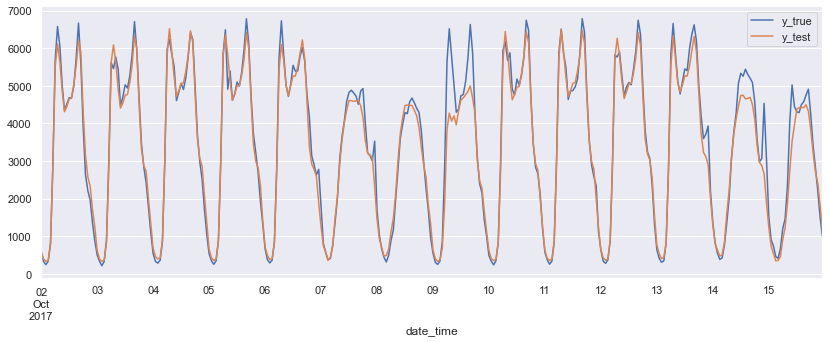

In [25]:
fig, ax = plt.subplots(figsize=(14,5))
preds_df.iloc[:lb*2].plot(ax=ax)
plt.show()

## 3) Introduction to Uncertainty Quantification

There are two types of UQ algorithms:

- Intrinsic
- Extrinsic

and they operate on two levels:

- Data
- Model

![Uncertainty Estimation Algorithms](https://uq360.mybluemix.net/imgs/taxonomy.png)

### 3.1) Extrinsic Algorithm: Conformal Prediction with MAPIE 

It leverages residuals of the validation datasets across multiple cross-validation folds, in addition to several perturbed models generated during the cross-validation, to produce the confidence intervals.

![MAPIE works](https://github.com/simai-ml/MAPIE/raw/master/doc/images/mapie_internals_regression.png)

#### 3.1.1) Initialize a new model (like previously fittted one)

In [26]:
lgb_mapie_reg = lgb.LGBMRegressor(random_state=rand, n_jobs=-1,\
                                  **best_params)

#### 3.1.2) Initialize a MAPIE regressor and fit it

In [27]:
%%time
mapie_reg = MapieRegressor(lgb_mapie_reg)
mapie_reg = mapie_reg.fit(X_train, y_train)

alpha = [0.05, 0.32]
y_mapie_pred, y_mapie_pis = mapie_reg.predict(X_test, alpha=alpha)

CPU times: user 39 s, sys: 21.1 s, total: 1min
Wall time: 52.3 s


#### 3.1.3) Compute coverage

In [29]:
coverage_score_l = [
    regression_coverage_score(y_test, y_mapie_pis[:, 0, i], y_mapie_pis[:, 1, i])
    for i, _ in enumerate(alpha)
]

print(coverage_score_l)

[0.9629120879120879, 0.7461080586080586]


#### 3.1.4) Examine predictions

In [30]:
preds_mapie_df = pd.DataFrame({'y_true':y_test, 'y_test': y_mapie_pred,\
                               'C0.68_lb':y_mapie_pis[:, 0, 1],\
                               'C0.68_ub':y_mapie_pis[:, 1, 1],\
                               'C0.95_lb':y_mapie_pis[:, 0, 0],\
                               'C0.95_ub':y_mapie_pis[:, 1, 0]})
preds_mapie_df

,y_true,y_test,C0.68_lb,C0.68_ub,C0.95_lb,C0.95_ub
date_time,,,,,,
2017-10-02 00:00:00,581,588.611351,331.179870,885.554555,-227.494655,1443.793434
2017-10-02 01:00:00,326,391.533811,112.471517,665.831456,-448.276388,1224.998613
2017-10-02 02:00:00,241,331.037331,63.245043,616.982897,-495.716674,1176.084952
2017-10-02 03:00:00,334,349.021166,75.093037,629.990847,-484.964837,1188.903295
2017-10-02 04:00:00,803,811.178359,506.591578,1061.058317,-50.597690,1621.273007
...,...,...,...,...,...,...
2018-09-30 19:00:00,3543,3213.061088,2990.592882,3548.813650,2434.549602,4111.556204
2018-09-30 20:00:00,2781,2680.500923,2410.521596,2967.517069,1850.230296,3525.614784
2018-09-30 21:00:00,2159,2344.265072,2116.373400,2682.082325,1555.983025,3242.995565


#### 3.1.5) Visualize uncertainty

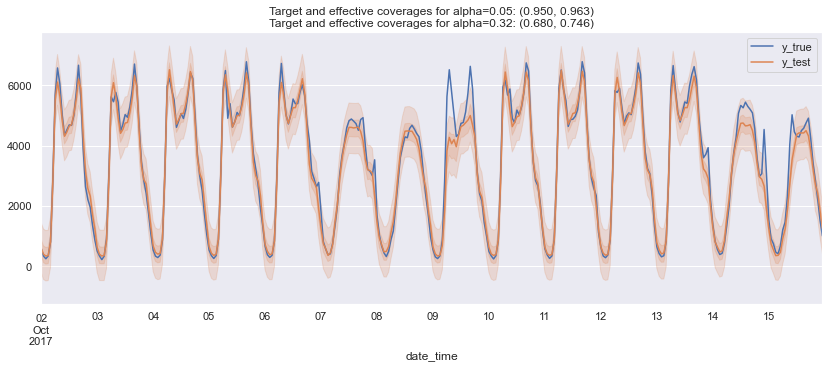

In [31]:
fig, ax = plt.subplots(figsize=(14,5))
preds_mapie_df.iloc[:lb*2,[0,1]].plot(ax=ax)
ax.fill_between(x=preds_mapie_df.index, y1=preds_mapie_df['C0.95_lb'],
                y2=preds_mapie_df['C0.95_ub'], color='C1', alpha=0.2)
ax.fill_between(x=preds_mapie_df.index, y1=preds_mapie_df['C0.68_lb'],
                y2=preds_mapie_df['C0.68_ub'], color='C1', alpha=0.2)
plt.title(
    f"Target and effective coverages for "
    f"alpha={alpha[0]:.2f}: ({1-alpha[0]:.3f}, {coverage_score_l[0]:.3f})\n"
    f"Target and effective coverages for "
    f"alpha={alpha[1]:.2f}: ({1-alpha[1]:.3f}, {coverage_score_l[1]:.3f})"
)
plt.show()

### 3.2) Intrinsic Algorithm: Quantile Regression

#### 3.2.1) Scale data

In [90]:
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).squeeze()
y_test_ = y_test.values.squeeze()

scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

#### 3.2.2) Initialize Quantile Regressor and fit it

In [101]:
%%time
qr_alpha = 0.05

config = {
    "alpha":1 - qr_alpha,
    "n_estimators":100,
    "max_depth":7,
    "learning_rate":0.1,
    "min_samples_leaf":20,
    "min_samples_split":20
}

uq_model = QuantileRegression(model_type='gbr', config=config)

uq_model = uq_model.fit(X_train_scaled, y_train_scaled)

/Users/serg/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:290: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  FutureWarning,


CPU times: user 42.2 s, sys: 208 ms, total: 42.4 s
Wall time: 42.8 s


**Get predictions and inverse transform them**

In [102]:
y_mean, y_lower, y_upper = uq_model.predict(X_test_scaled)
y_mean, y_lower, y_upper = scaler_y.inverse_transform(y_mean.reshape(-1, 1)),\
                           scaler_y.inverse_transform(y_lower.reshape(-1, 1)),\
                           scaler_y.inverse_transform(y_upper.reshape(-1, 1))

#### 3.2.3) Examine the predictions

In [104]:
preds_qr_df = pd.DataFrame({'y_true':y_test, 'y_test': y_mean[:,0],\
                               'C0.95_lb':y_lower[:,0],\
                               'C0.95_ub':y_upper[:,0]})
preds_qr_df

,y_true,y_test,C0.95_lb,C0.95_ub
date_time,,,,
2017-10-02 00:00:00,581,568.300084,484.619302,903.535510
2017-10-02 01:00:00,326,382.130697,307.341137,456.225448
2017-10-02 02:00:00,241,297.717045,256.081964,389.189681
2017-10-02 03:00:00,334,357.867481,316.868754,399.259590
2017-10-02 04:00:00,803,837.433155,773.327830,921.978829
...,...,...,...,...
2018-09-30 19:00:00,3543,3320.905695,2483.976430,3835.452599
2018-09-30 20:00:00,2781,2685.426640,2211.277147,3501.871934
2018-09-30 21:00:00,2159,2363.585298,1978.541420,3010.190906


#### 3.2.4) Compute the coverage

In [113]:
coverage_score = regression_coverage_score(y_test, y_lower[:,0], y_upper[:,0])
print(coverage_score)

0.8968635531135531


It's also known as the prediction interval coverage probability (PICP):

In [112]:
picp(y_test, y_lower[:,0], y_upper[:,0])

0.8968635531135531

and there's also another metric called mean prediction interval width (MPIW):

In [114]:
mpiw(y_lower, y_upper)

1113.3009331891658

#### 3.1.5) Visualize uncertainty

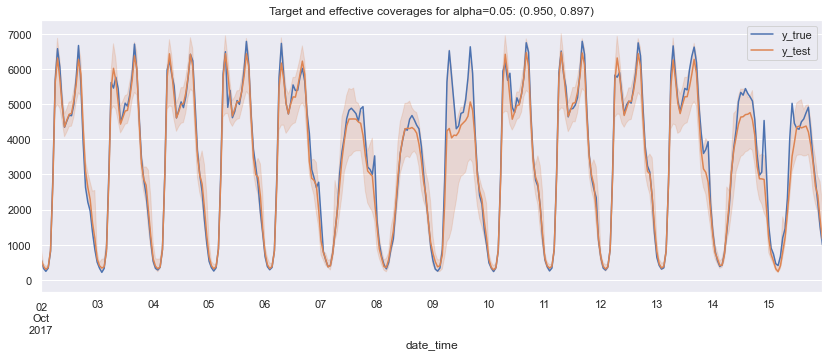

In [110]:
fig, ax = plt.subplots(figsize=(14,5))
preds_qr_df.iloc[:lb*2,[0,1]].plot(ax=ax)
ax.fill_between(x=preds_qr_df.index, y1=preds_qr_df['C0.95_lb'],
                y2=preds_qr_df['C0.95_ub'], color='C1', alpha=0.2)
plt.title(
    f"Target and effective coverages for "
    f"alpha={qr_alpha:.2f}: ({1-qr_alpha:.3f}, {coverage_score:.3f})"
)
plt.show()

## 5) Read More

- [Guidance on Choosing UQ Algorithms and Metrics](https://uq360.mybluemix.net/resources/guidance) 
- [UUQ360 Quantile Regression Documentation](https://uq360.readthedocs.io/en/latest/intrinsic.html#quantile-regression)
- [MAPIE - Model Agnostic Prediction Interval Estimator Repository](https://github.com/scikit-learn-contrib/MAPIE)
- [MAPIE - Model Agnostic Prediction Interval Estimator Documentation](https://mapie.readthedocs.io/en/latest/)